In [39]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity
from scipy.stats.distributions import norm
from sklearn.grid_search import GridSearchCV

def tuples_to_xy(tuples):
    tmp = np.transpose(tuples)
    return tmp[0], tmp[1]

def norm_on_range(x, y, x_range=None, y_range=None):
    if x_range is None:
        x_range = (min(x), max(x))
    if y_range is None:
        y_range = (min(y), max(y))
    x_measured_range = [min(x), max(x)]
    y_measured_range = [min(y), max(y)]
    
    x = [(xx - x_measured_range[0]) / (x_measured_range[1] - x_measured_range[0]) for xx in x]
    y = [(yy - y_measured_range[0]) / (y_measured_range[1] - y_measured_range[0]) for yy in y]
    
    x = [(xx + x_range[0]) * (x_range[1] - x_range[0]) for xx in x]
    y = [(yy + y_range[0]) * (y_range[1] - y_range[0]) for yy in y]
    return x, y

def KDEiPosition(points, title=None, show=False, save_to=None, bandwidth=None, show_points=False):
    x, y = tuples_to_xy(points)
    x, y = norm_on_range(x, y, x_range=(0, 1), y_range=(0, 1))

    x = np.array(x)
    y = np.array(y)

    xy_train  = np.vstack([y, x]).T
    if bandwidth is None:
        grid = GridSearchCV(KernelDensity(kernel='gaussian'),  # 'tophat' is other option that allows sampling
                            {'bandwidth': np.linspace(0.1, 1.0, 5)},
                            cv=20) # 20-fold cross-validation
        grid.fit(xy_train)
        print(grid.best_params_)

        kde = grid.best_estimator_
    else:
        grid = GridSearchCV(KernelDensity(kernel='gaussian'),  # 'tophat' is other option that allows sampling
                            {'bandwidth': np.linspace(bandwidth, bandwidth, 1)},
                            cv=20) # 20-fold cross-validation
        grid.fit(xy_train)
        print(grid.best_params_)

        kde = grid.best_estimator_
    # Create grid of sample locations (default: 100x100)
    xx, yy = np.mgrid[0:1:100j, 
                      0:1:100j]

    xy_sample = np.vstack([yy.ravel(), xx.ravel()]).T

    pdf = np.exp(kde.score_samples(xy_sample))
    
    if show or save_to is not None:
        with plt.rc_context():
            ax = plt.subplot(111)
            plt.pcolormesh(xx, yy, np.reshape(pdf, xx.shape))
            if show_points:
                plt.scatter(x, y, s=0.5, color='white')
            plt.xlim(0, 1)
            plt.ylim(0, 1)
            plt.axis([0., 1., 0., 1.])
            #plt.axis('equal')
            if title is not None:
                plt.title(title)
            if show:
                plt.show()
            if save_to is not None:
                plt.savefig(save_to, dpi=600)
            
    return kde

def RenderKDE(kde, title=None, show=False, save_to=None):
    # Create grid of sample locations (default: 100x100)
    xx, yy = np.mgrid[0:1:100j, 
                      0:1:100j]

    xy_sample = np.vstack([yy.ravel(), xx.ravel()]).T
    
    pdf = np.exp(kde.score_samples(xy_sample))
    
    if show or save_to is not None:
        with plt.rc_context():
            ax = plt.subplot(111)
            plt.pcolormesh(xx, yy, np.reshape(pdf, xx.shape))
            plt.xlim(0, 1)
            plt.ylim(0, 1)
            plt.axis([0., 1., 0., 1.])
            #plt.axis('equal')
            if title is not None:
                plt.title(title)
            if save_to is not None:
                plt.savefig(save_to, dpi=600)
            if show:
                plt.show()

def save_model(model, filename):
    from sklearn.externals import joblib
    joblib.dump(model, filename)
    
def load_model(filename):
    from sklearn.externals import joblib
    return joblib.load(filename)

def generate_kdes(points, bandwidth=None):
    kdes = []
    for idx, ps in enumerate(points):
        print('Finding KDE for bin {0}/{1}.'.format(idx, len(points)))
        kde = KDEiPosition(ps, save_to='{0}.png'.format(idx), bandwidth=bandwidth)
        save_model(kde, '{0}.pkl'.format(idx))
        kdes.append(kde)
        
    return kdes

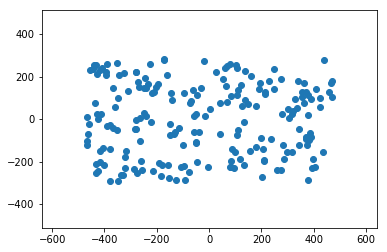

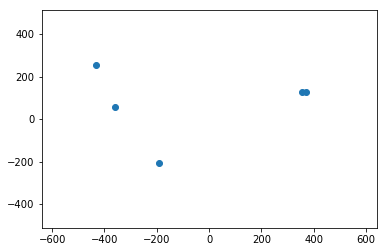

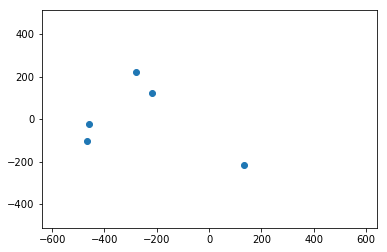

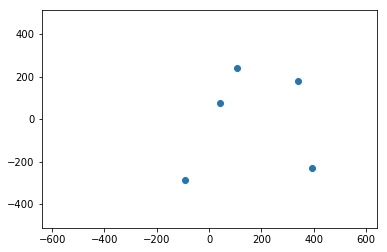

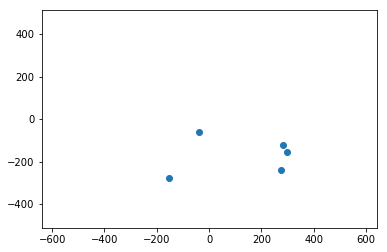

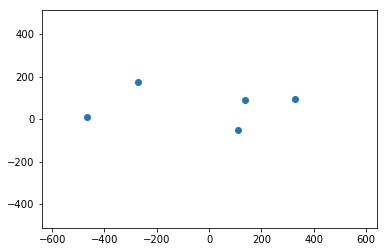

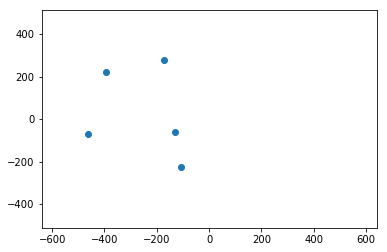

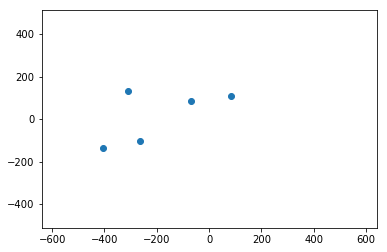

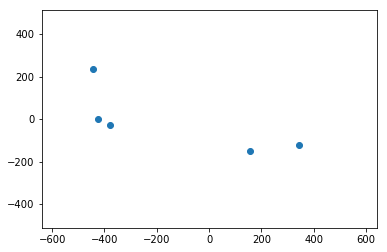

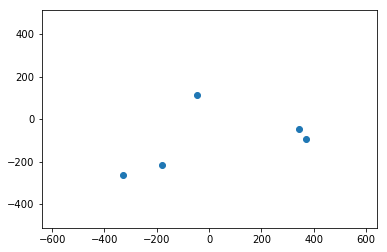

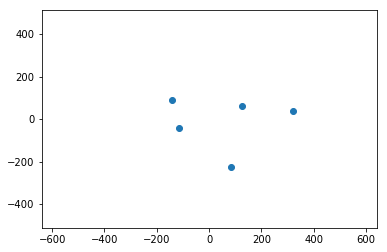

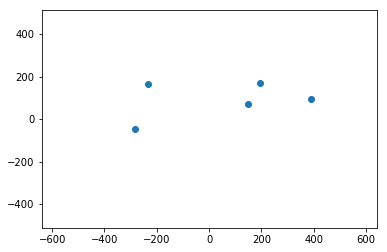

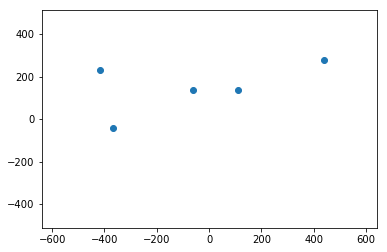

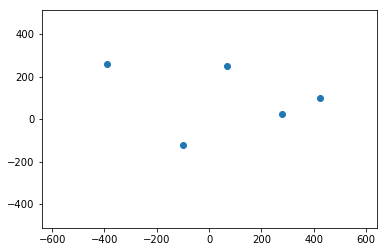

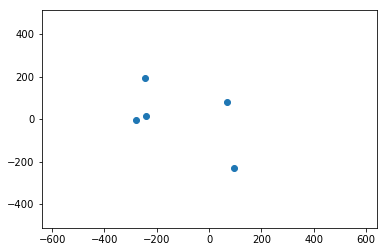

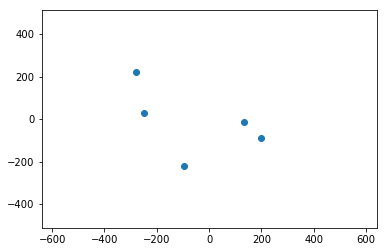

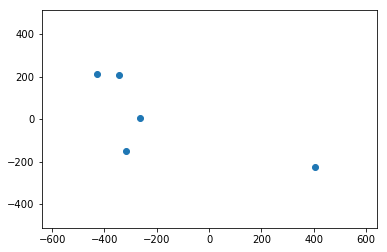

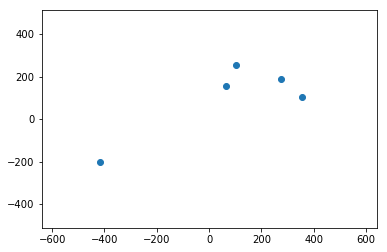

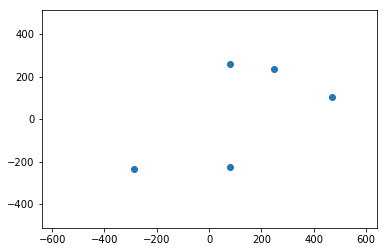

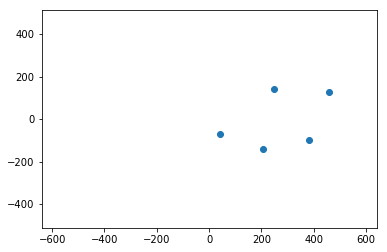

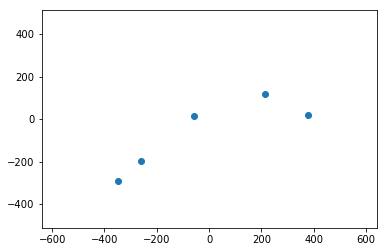

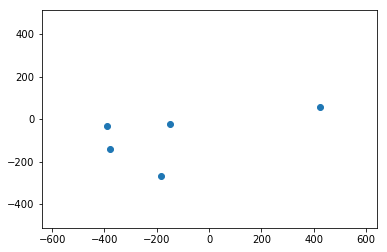

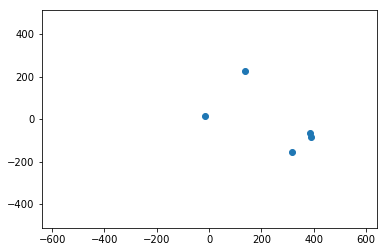

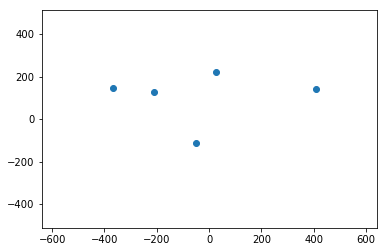

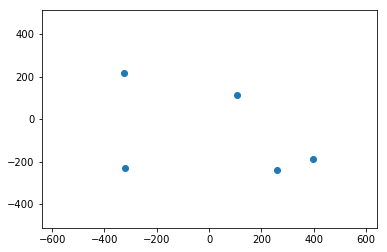

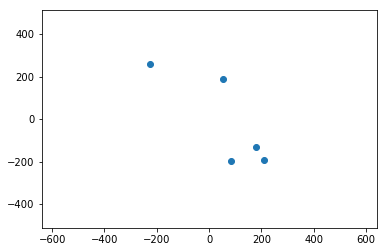

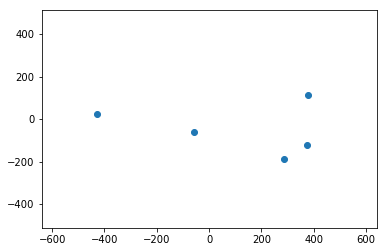

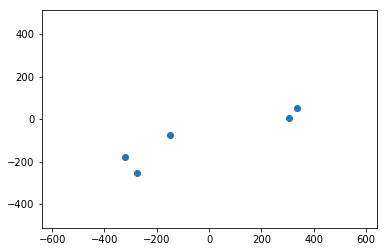

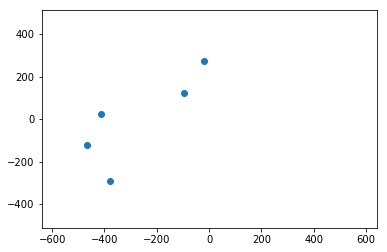

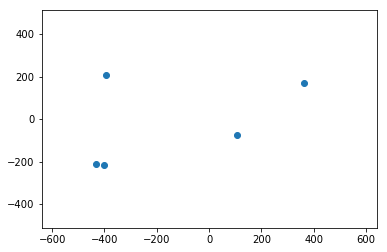

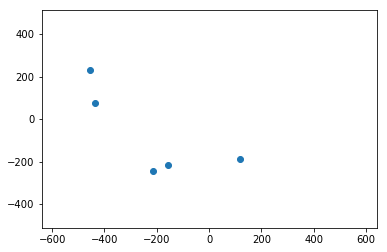

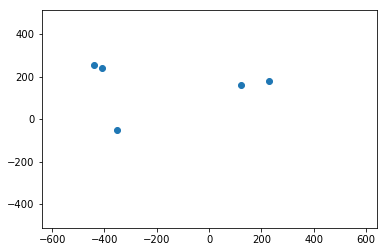

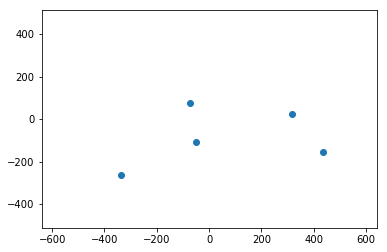

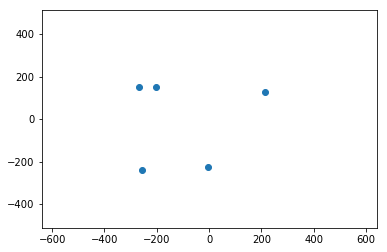

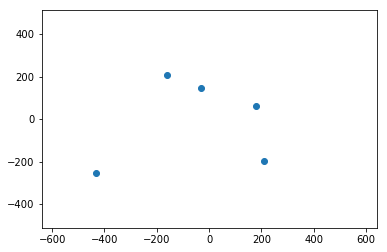

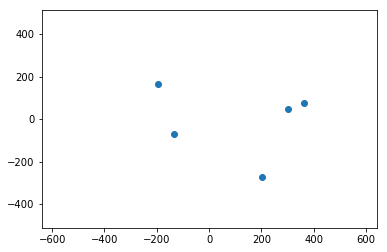

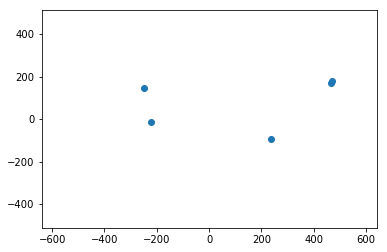

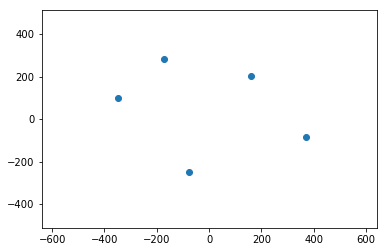

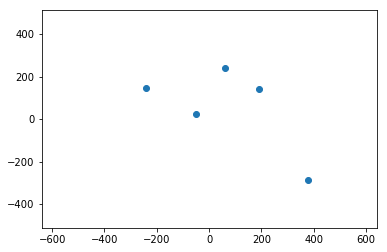

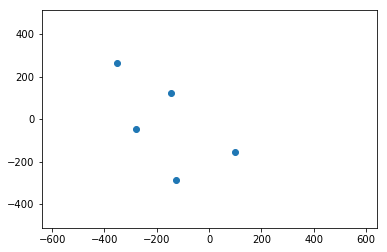

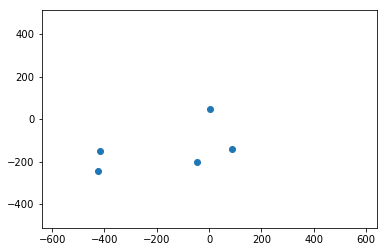

In [84]:
scale = (950, 600)
offset = (-475, -300)
shape = (2, 20, 5)
vis_bounds = (1280, 1024)
extents = (-vis_bounds[0]/2, vis_bounds[0]/2, -vis_bounds[1]/2, vis_bounds[1]/2)
points = np.random.rand(np.prod(shape), 2) * scale + offset
points_reshaped = np.reshape(points, shape+(2,))
plt.scatter(*points.transpose())
plt.xlim(extents[0], extents[1])
plt.ylim(extents[2], extents[3])
plt.show()

for p0 in points_reshaped:
    for p1 in p0:
        plt.scatter(*p1.transpose())
        plt.xlim(extents[0], extents[1])
        plt.ylim(extents[2], extents[3])
        plt.show()

(-640, 640, -512, 512)


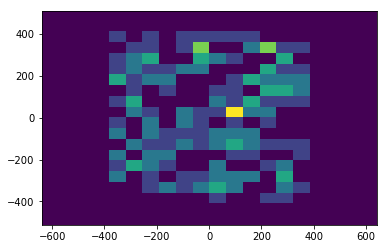

In [82]:

H, _, _ = np.histogram2d(*points.transpose(), bins=20, range=np.reshape(extents, (2, 2)))
print(extents)
plt.imshow(H, extent=extents, aspect=1./1.25)
plt.show()

{'bandwidth': 0.10000000000000001}


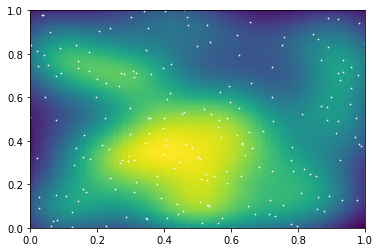

KernelDensity(algorithm='auto', atol=0, bandwidth=0.10000000000000001,
       breadth_first=True, kernel='gaussian', leaf_size=40,
       metric='euclidean', metric_params=None, rtol=0)

In [73]:
KDEiPosition(points, show=True, show_points=True)

In [61]:
decimal_places = 0
for idx, group in enumerate(points_reshaped):
    with open('{0}_actual_coordinates.txt'.format(idx), 'wb') as fp:
        for line_data in group:
            pts = line_data.reshape(np.prod(line_data.shape))
            line = '\t'.join(["{0:.{1}f}".format(p,decimal_places) for p in pts])
            fp.write(line + "\r\n")